# Dynamic Time Warping

Dynamic Time Warping is a technique which tries to fit one Curve onto another. It tells how expensive that "fitting" is and also which points on one curve corresponds to points on another curve. The neat thing about DTW is that the two curves can be of different size. You can check out more about DTW [here](https://www.youtube.com/watch?v=ERKDHZyZDwA).

> Please note that this Notebook is inspired by the awesome DTW Tutorials mentioned in the link above and borrows some stuff from this Notebook [here](https://github.com/kamperh/lecture_dtw_notebook/blob/main/dtw.ipynb)

## Implementation of DTW Algorithm

In [1]:
def dp(dist_mat):
    """
    This function was borred from here: https://github.com/kamperh/lecture_dtw_notebook/blob/main/dtw.ipynb
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

In [2]:
def calculate_dist_mat(x, y):
    N = x.shape[0]
    M = y.shape[0]
    dist_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            dist_mat[i, j] = abs(x[i] - y[j])
    return dist_mat

## Try out Algorithm
* Precalculate the Distance Matrix
* Run the DTW Algorithm for two datasets we wish to compare
* Get the Alignment Cost and Normalized Alignment Cost (tells us how "costly" is is to transform one dataset to another one)
* Show which points from one series map to points from another series

(-0.6000000000000001, 12.6, -2.75, 2.75)

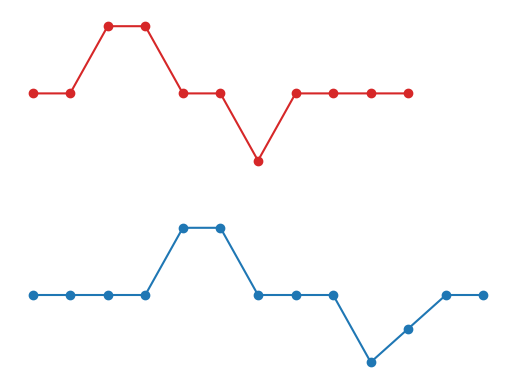

In [3]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np

PLOT_OFFSET = 1.5

x = np.array([0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0])
y = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -0.5, 0, 0])

plt.plot(np.arange(x.shape[0]), x + PLOT_OFFSET, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - PLOT_OFFSET, "-o", c="C0")
plt.axis("off")


In [4]:
dist_mat = calculate_dist_mat(x, y)
N, M = dist_mat.shape
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

Alignment cost: 0.5000
Normalized alignment cost: 0.0208


(-0.6000000000000001, 12.6, -2.75, 2.75)

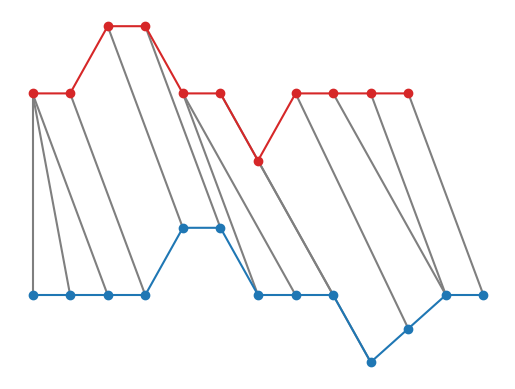

In [5]:
plt.figure()
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + PLOT_OFFSET, y[y_j] - PLOT_OFFSET], c="C7")
plt.plot(np.arange(x.shape[0]), x + PLOT_OFFSET, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - PLOT_OFFSET, "-o", c="C0")
plt.axis("off")

## Introduce Helper Methods based on the code above

In [6]:
def compare_datasets(x, y, plot = True):
    PLOT_OFFSET = 1.5
    dist_mat = calculate_dist_mat(x, y)
    N, M = dist_mat.shape
    path, cost_mat = dp(dist_mat)

    if plot:
        plt.figure()
        for x_i, y_j in path:
            plt.plot([x_i, y_j], [x[x_i] + PLOT_OFFSET, y[y_j] - PLOT_OFFSET], c="C7")
        plt.plot(np.arange(x.shape[0]), x + PLOT_OFFSET, "-o", c="C3")
        plt.plot(np.arange(y.shape[0]), y - PLOT_OFFSET, "-o", c="C0")
        plt.axis("off")

    alignment_cost = cost_mat[N - 1, M - 1]
    normalized_alignment_cost = cost_mat[N - 1, M - 1]/(N + M)
    return (alignment_cost, normalized_alignment_cost)

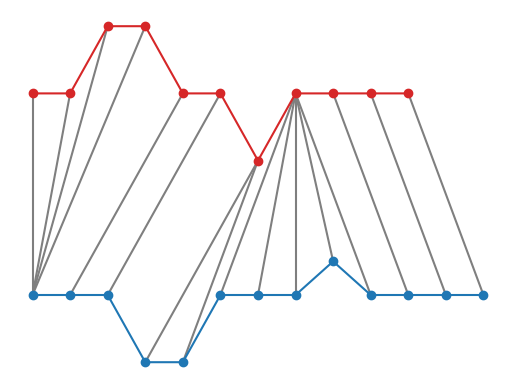

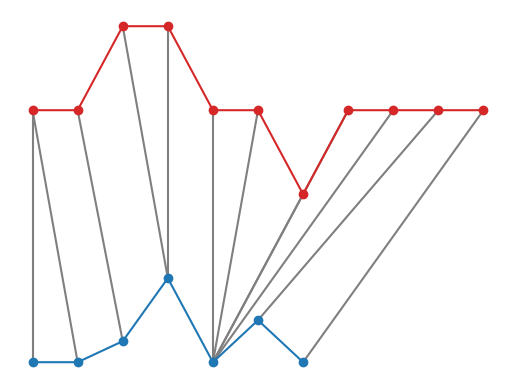

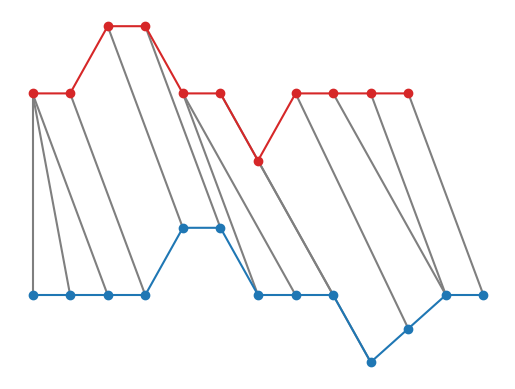

In [7]:
a = np.array([0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0])
b = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -0.5, 0, 0])
c = np.array([0, 0, 0, -1, -1, 0, 0, 0, 0.5, 0, 0, 0, 0])
d = np.array([0, 0, 0.25, 1, 0, 0.5, 0])
    
for compare_with in [c, d, b]:
    compare_datasets(a, compare_with)

## Load and Diplay Tracking Data (pb Files)

### Helper Methods

In [8]:
def create_df_from_tracking_data(tracking_data):
	df = []
	for frame in tracking_data.frameData:
		# For some reason we can get two elements in poseData which messes up the structure of the dataframe.
		# TODO: Check why we get two poses (e.g frame 21 in file ./data/test/track_data/guemah_forehand_flat_02out.pb)
		if len(frame.poseData) > 1:
			print(f"Got multiple pose data for frame {frame.index}")
		for pose in frame.poseData:
			# We are only interested in poses with id 0, skip the rest. This only occurs when we have multiple pose data per frame.
			if pose.id != 0:
				continue
			for keypoint in pose.keyPoints:
				# add frame and keypoint information to array
				df.append([frame.index, pose.id, keypoint.type, keypoint.posX, keypoint.posY, keypoint.absPosX, keypoint.absPosY, keypoint.absPosZ])

	df = pd.DataFrame(df, columns=["frame", "pose", "keypoint", "x", "y", "absX", "absY", "absZ"])
	df = df.pivot(index=["frame", "pose"], columns="keypoint", values=["x", "y", "absX", "absY", "absZ"])
	df = df.swaplevel(axis=1)
	return df

In [9]:
def load_tracking_data(file_path):
    with open(file_path, "rb") as f:
        # create tracking data object
        tracking_data = trackingDataPb_pb2.trackingData()
        
        # parse string from file
        tracking_data.ParseFromString(f.read())
    return tracking_data

### Plot Backhand Tracking Data with X-Coordinate

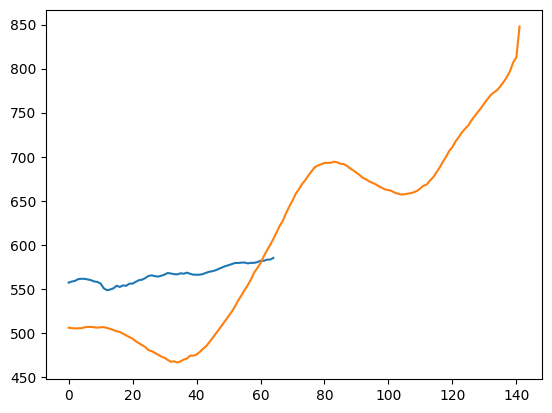

In [83]:
import trackingDataPb_pb2
import pandas as pd

file_path = "./data/features/backhand/track_data/guemah_backhand_01.pb"
tracking_data = load_tracking_data(file_path)
df = create_df_from_tracking_data(tracking_data)
x = df.loc[:,pd.IndexSlice[1,['x']]].values
plt.plot(x)

file_path = "./data/features/backhand/track_data/yhu_backhand_01.pb"
tracking_data = load_tracking_data(file_path)
df = create_df_from_tracking_data(tracking_data)
x = df.loc[:,pd.IndexSlice[1,['x']]].values
plt.plot(x)

### Introduce Helper Method for extracting certain keypoints given two pb files.

In [84]:
def get_feature_keypoints_from_pb_files(file_path_a, file_path_b, keypoint_a, keypoint_b, feature):
    
    tracking_data_a = load_tracking_data(file_path_a)
    tracking_data_b = load_tracking_data(file_path_b)
    
    df_a = create_df_from_tracking_data(tracking_data_a)
    df_b = create_df_from_tracking_data(tracking_data_b)

    kp_a = df_a.loc[:,pd.IndexSlice[keypoint_a,[feature]]].values.squeeze()
    kp_b = df_b.loc[:,pd.IndexSlice[keypoint_b,[feature]]].values.squeeze()

    normalized_kp_a = (kp_a-np.min(kp_a))/(np.max(kp_a)-np.min(kp_a)) 
    normalized_kp_b = (kp_b-np.min(kp_b))/(np.max(kp_b)-np.min(kp_b)) 
    return (normalized_kp_a, normalized_kp_b)

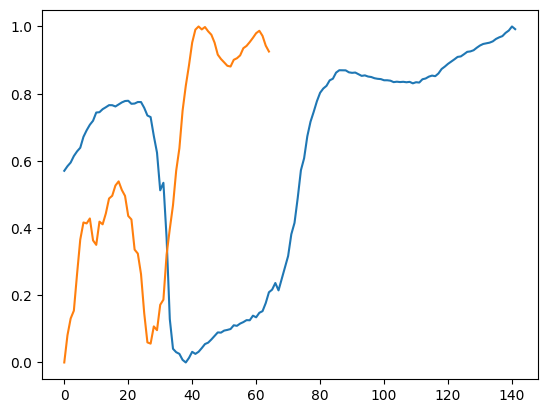

In [86]:
file_path_a = "./data/features/backhand/track_data/yhu_backhand_01.pb"
file_path_b = "./data/features/backhand/track_data/guemah_backhand_01.pb"
keypoint_a = 23
keypoint_b = 22
kp_a, kp_b = get_feature_keypoints_from_pb_files(file_path_a, file_path_b, keypoint_a, keypoint_b, "x")

plt.plot(kp_a)
plt.plot(kp_b)

### Compare with DTW

(11.825161605146587, 0.05712638456592554)

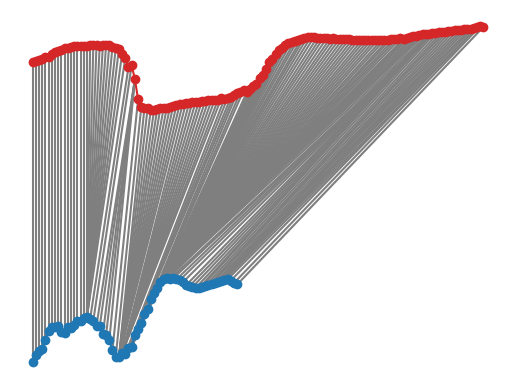

In [88]:
compare_datasets(kp_a, kp_b)

### Introduce Helper Method for comparing two pb files given a certain keypoint and feature

In [15]:
def compare_pb_files(file_path_a, file_path_b, keypoint_a, keypoint_b, feature):
    kp_a, kp_b = get_feature_keypoints_from_pb_files(file_path_a, file_path_b, keypoint_a, keypoint_b, feature)
    plt.plot(kp_a)
    plt.title(file_path_a)
    plt.show()
    plt.plot(kp_b)
    plt.title(file_path_b)
    plt.show()
    compare_datasets(kp_a, kp_b)

## Forehand Flat

### Y Coordinate

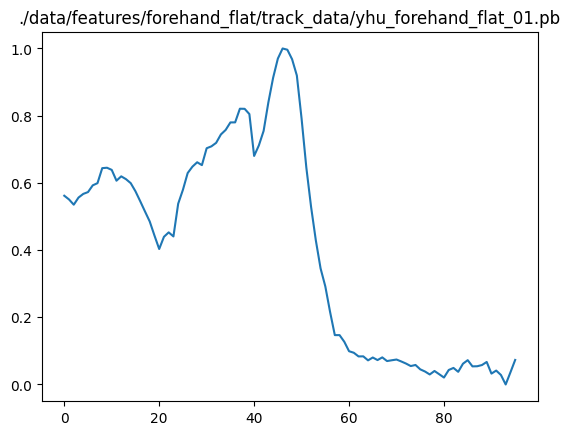

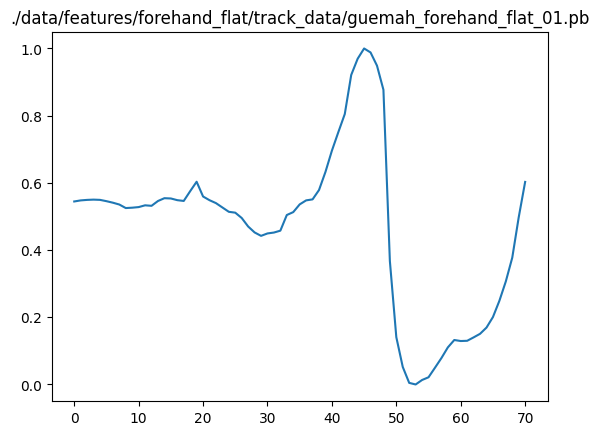

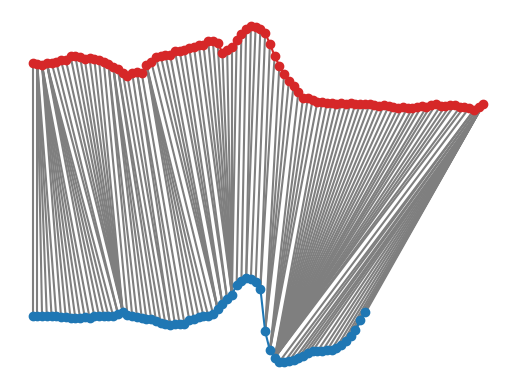

In [89]:
file_path_a = "./data/features/forehand_flat/track_data/yhu_forehand_flat_01.pb"
file_path_b = "./data/features/forehand_flat/track_data/guemah_forehand_flat_01.pb"
keypoint_a = 23
keypoint_b = 23
compare_pb_files(file_path_a, file_path_b, keypoint_a, keypoint_b, "y")

### X Coordinate

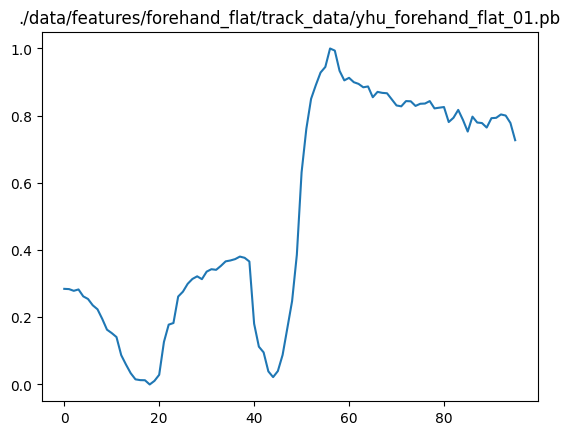

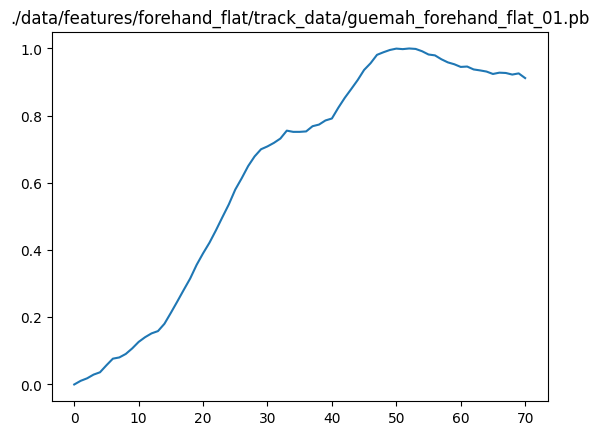

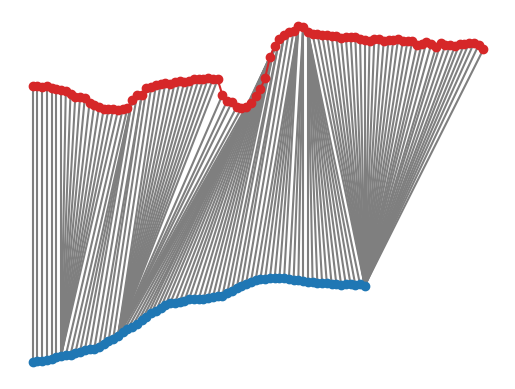

In [90]:
file_path_a = "./data/features/forehand_flat/track_data/yhu_forehand_flat_01.pb"
file_path_b = "./data/features/forehand_flat/track_data/guemah_forehand_flat_01.pb"
keypoint_a = 23
keypoint_b = 22
compare_pb_files(file_path_a, file_path_b, keypoint_a, keypoint_b, "x")

### Abs X Position

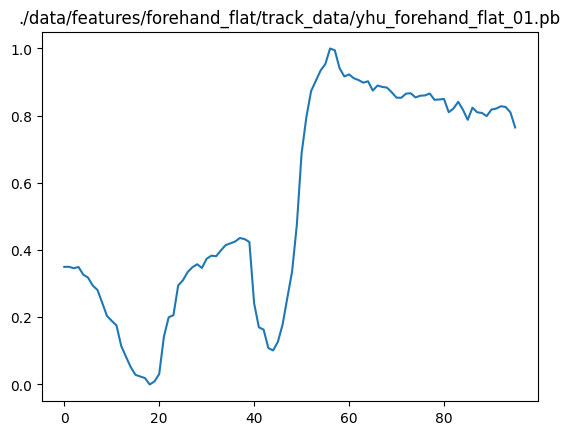

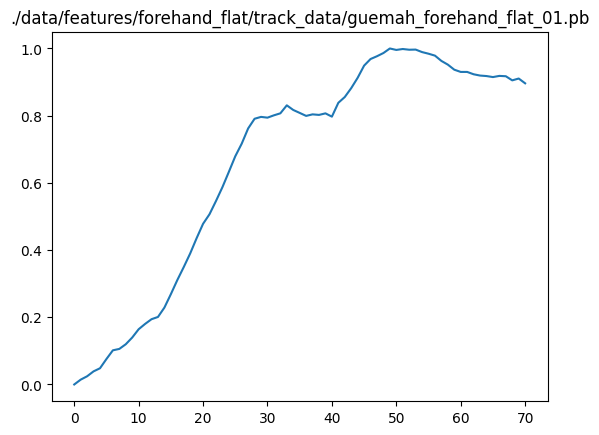

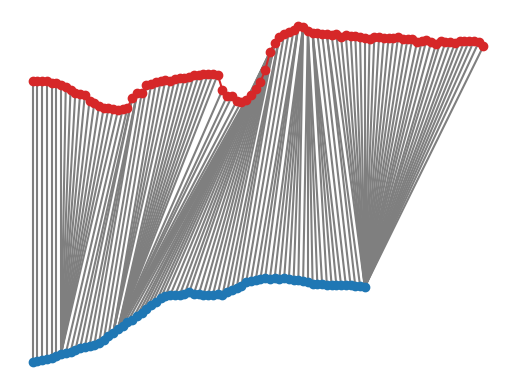

In [91]:
file_path_a = "./data/features/forehand_flat/track_data/yhu_forehand_flat_01.pb"
file_path_b = "./data/features/forehand_flat/track_data/guemah_forehand_flat_01.pb"
keypoint_a = 23
keypoint_b = 22
compare_pb_files(file_path_a, file_path_b, keypoint_a, keypoint_b, "absX")

### Abs Y Position

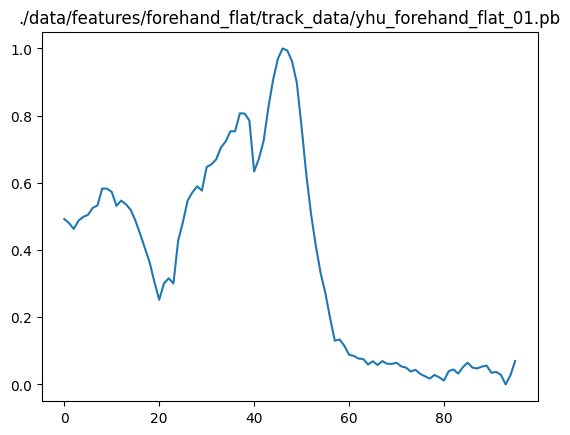

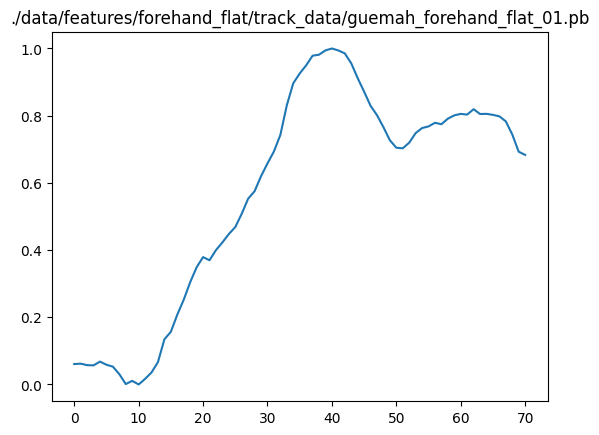

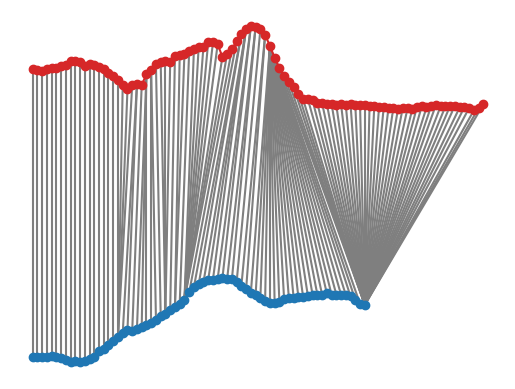

In [92]:
file_path_a = "./data/features/forehand_flat/track_data/yhu_forehand_flat_01.pb"
file_path_b = "./data/features/forehand_flat/track_data/guemah_forehand_flat_01.pb"
keypoint_a = 23
keypoint_b = 22
compare_pb_files(file_path_a, file_path_b, keypoint_a, keypoint_b, "absY")

### Elbow Angle

In [99]:
import vg

def get_elbow_angle(tracking_data, smooth = True, is_left = True):
    df = create_df_from_tracking_data(tracking_data)
    if is_left:
        kp16 = df.loc[:,pd.IndexSlice[16,["absX", "absY", "absZ"]]].values
        kp18 = df.loc[:,pd.IndexSlice[18,["absX", "absY", "absZ"]]].values
        kp20 = df.loc[:,pd.IndexSlice[20,["absX", "absY", "absZ"]]].values
        vg16_18 = kp16 - kp18
        vg18_20 = kp18 - kp20
        result = vg.angle(vg16_18, vg18_20)
    else:
        kp17 = df.loc[:,pd.IndexSlice[17,["absX", "absY", "absZ"]]].values
        kp19 = df.loc[:,pd.IndexSlice[19,["absX", "absY", "absZ"]]].values
        kp21 = df.loc[:,pd.IndexSlice[21,["absX", "absY", "absZ"]]].values
        vg17_19 = kp17 - kp19
        vg19_21 = kp19 - kp21
        result = vg.angle(vg17_19, vg19_21)
    if smooth:
        result = pd.Series(result).rolling(5, center = True, min_periods=1).mean().values
    return result
    

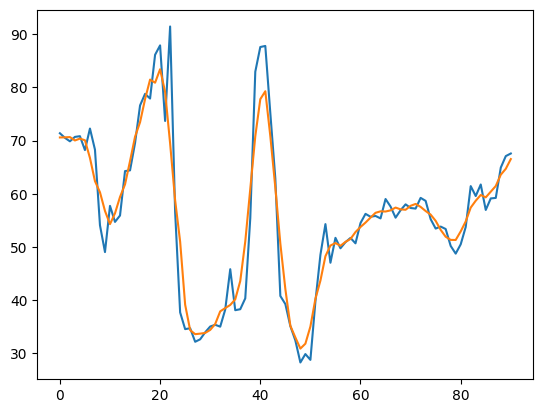

In [100]:
file_path = "./data/features/forehand_flat/track_data/yhu_forehand_flat_02.pb"
tracking_data = load_tracking_data(file_path)
elbow_angle_raw = get_elbow_angle(tracking_data, smooth = False, is_left = False)
plt.plot(elbow_angle_raw)
elbow_angle_smooth = get_elbow_angle(tracking_data, smooth = True, is_left = False)
plt.plot(elbow_angle_smooth)


231.94440776246796 1.274419822870703


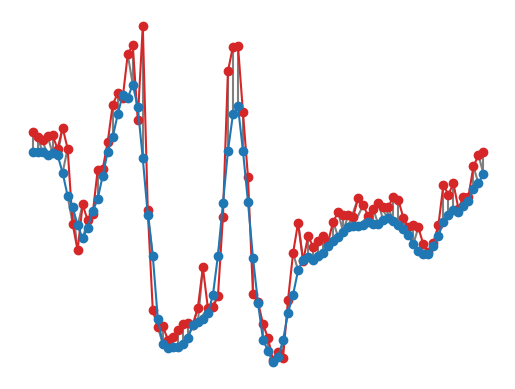

In [101]:
elbow_angle_smooth
alignment_cost, normalized_alignment_cost = compare_datasets(elbow_angle_raw, elbow_angle_smooth)
print(alignment_cost, normalized_alignment_cost)

Got multiple pose data for frame 21
Got multiple pose data for frame 22
Got multiple pose data for frame 32
Got multiple pose data for frame 34
Got multiple pose data for frame 35
Got multiple pose data for frame 21
Got multiple pose data for frame 22
Got multiple pose data for frame 32
Got multiple pose data for frame 34
Got multiple pose data for frame 35


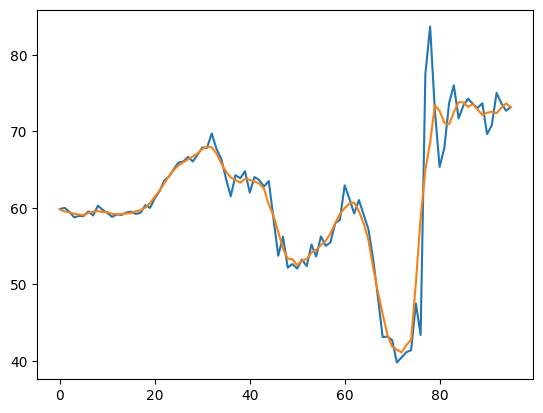

In [102]:
file_path = "./data/features/forehand_flat/track_data/guemah_forehand_flat_02.pb"
tracking_data = load_tracking_data(file_path)
elbow_angle_raw = get_elbow_angle(tracking_data, smooth = False, is_left = True)
plt.plot(elbow_angle_raw)
elbow_angle_smooth = get_elbow_angle(tracking_data, smooth = True, is_left = True)
plt.plot(elbow_angle_smooth)

119.46074524309222 0.6221913814744386


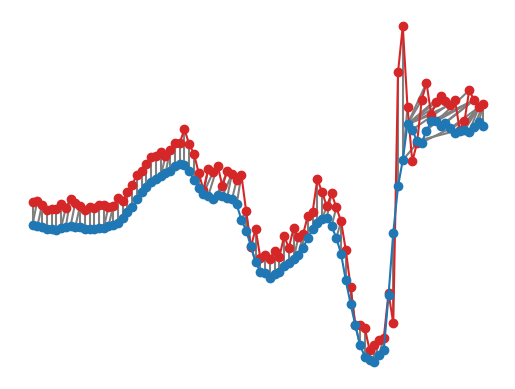

In [103]:
elbow_angle_smooth
alignment_cost, normalized_alignment_cost = compare_datasets(elbow_angle_raw, elbow_angle_smooth)
print(alignment_cost, normalized_alignment_cost)

## Classification

### Hand

#### X Coordinate

In [124]:
def get_hand_x_pos(tracking_data, smooth = True, is_left = True):
    df = create_df_from_tracking_data(tracking_data)
    if is_left:
        kp_index = 22
    else:
        kp_index = 23
    result = df.loc[:,pd.IndexSlice[kp_index,["x"]]].values.squeeze()
    if smooth:
        result = pd.Series(result).rolling(5, center = True, min_periods=1).mean().values
    return result

In [162]:
import sys

def classify_with_hand(train_config, test_data_file_path, smooth = True):
    # Load train data (for left and right)
    train_data_left = []
    train_data_right = []
    train_data_paths_right = []
    train_data_paths_left = []
    file_path_to_classification_mapping = {}
    train_config_left = [config for config in train_config if config["is_left"] == True]
    train_config_right = [config for config in train_config if config["is_left"] == False]
    
    for config in train_config_left:
        file_path = config["file_path"]
        file_path_to_classification_mapping[file_path] = config["classification"]
        tracking_data = load_tracking_data(file_path)
        hand_x_pos = get_hand_x_pos(tracking_data, smooth, is_left = True) 
        train_data_left.append(hand_x_pos)
        train_data_paths_left.append(file_path)

    for config in train_config_right:
        file_path = config["file_path"]
        file_path_to_classification_mapping[file_path] = config["classification"]
        tracking_data = load_tracking_data(file_path)
        hand_x_pos = get_hand_x_pos(tracking_data, smooth, is_left = False) 
        train_data_right.append(hand_x_pos)
        train_data_paths_right.append(file_path)
        
     # Load test data (for left and right)
    test_tracking_data = load_tracking_data(test_data_file_path)
    test_hand_x_pos_left = get_hand_x_pos(test_tracking_data, smooth, is_left = True)
    test_hand_x_pos_right = get_hand_x_pos(test_tracking_data, smooth, is_left = False)

    # Define classification results
    classification_result_left = {
        "classification": "None",
        "file_path": "None",
        "cost": sys.maxsize
    }

    classification_result_right = {
        "classification": "None",
        "file_path": "None",
        "cost": sys.maxsize
    }
    
    # Check Left
    print(f"Checking Left")
    for config in train_config_left:
        print(".", end = " ")
        for index, compare_with in enumerate(train_data_left):
            alignment_cost, normalized_alignment_cost = compare_datasets(test_hand_x_pos_left, compare_with, False)
            train_data_file_path = train_data_paths_left[index]
            if alignment_cost < classification_result_left["cost"]:
                new_classification = file_path_to_classification_mapping[train_data_file_path]
                classification_result_left["cost"] = alignment_cost
                classification_result_left["classification"] = new_classification
                classification_result_left["file_path"] = train_data_file_path

    # Check Right
    print()
    print("Checking Right")
    for config in train_config_right:
        print(".", end = " ")
        for index, compare_with in enumerate(train_data_right):
            alignment_cost, normalized_alignment_cost = compare_datasets(test_hand_x_pos_right, compare_with, False)
            train_data_file_path = train_data_paths_right[index]
            if alignment_cost < classification_result_right["cost"]:
                new_classification = file_path_to_classification_mapping[train_data_file_path]
                classification_result_right["cost"] = alignment_cost
                classification_result_right["classification"] = new_classification
                classification_result_right["file_path"] = train_data_file_path

    print()
    if classification_result_right["cost"] < classification_result_left["cost"]:
        print(f"Best classification was {classification_result_right}")
    else:
        print(f"Best classification was {classification_result_left}")

In [163]:
train_config = [
    {
        "file_path": "./data/features/forehand_flat/track_data/yhu_forehand_flat_01.pb",
        "is_left": False,
        "classification": "Forehand Flat Rechts"
    },
    {
        "file_path": "./data/features/forehand_flat/track_data/yhu_forehand_flat_02.pb",
        "is_left": False,
        "classification": "Forehand Flat Rechts"
    },
    {
        "file_path": "./data/features/forehand_flat/track_data/guemah_forehand_flat_01.pb",
        "is_left": True,
        "classification": "Forehand Flat Links"
    },
    {
        "file_path": "./data/features/forehand_flat/track_data/guemah_forehand_flat_02.pb",
        "is_left": True,
        "classification": "Forehand Flat Links"
    },
    {
        "file_path": "./data/features/backhand/track_data/yhu_backhand_01.pb",
        "is_left": False,
        "classification": "Backhand Rechts"
    },
    {
        "file_path": "./data/features/backhand/track_data/yhu_backhand_02.pb",
        "is_left": False,
        "classification": "Backhand Rechts"
    },
    {
        "file_path": "./data/features/backhand/track_data/guemah_backhand_01.pb",
        "is_left": True,
        "classification": "Backhand Links"
    },
    {
        "file_path": "./data/features/backhand/track_data/guemah_backhand_02.pb",
        "is_left": True,
        "classification": "Backhand Links"
    },
    {
        "file_path": "./data/features/service_flat/track_data/yhu_service_flat_01.pb",
        "is_left": False,
        "classification": "Service Flat Rechts"
    },
    {
        "file_path": "./data/features/service_flat/track_data/yhu_service_flat_02.pb",
        "is_left": False,
        "classification": "Service Flat Rechts"
    },
    {
        "file_path": "./data/features/service_flat/track_data/guemah_service_flat_01.pb",
        "is_left": True,
        "classification": "Service Flat Links"
    },
    {
        "file_path": "./data/features/service_flat/track_data/guemah_service_flat_02.pb",
        "is_left": True,
        "classification": "Service Flat Links"
    },
]

test_data_path = "./data/features/forehand_flat/track_data/yhu_forehand_flat_03.pb"
classify_with_hand(train_config, test_data_path, True)

Got multiple pose data for frame 21
Got multiple pose data for frame 22
Got multiple pose data for frame 32
Got multiple pose data for frame 34
Got multiple pose data for frame 35
Got multiple pose data for frame 35
Got multiple pose data for frame 36
Got multiple pose data for frame 77
Got multiple pose data for frame 80
Got multiple pose data for frame 81
Checking Left
. . . . . . 
Checking Right
. . . . . . 
Best classification was {'classification': 'Service Flat Links', 'file_path': './data/features/service_flat/track_data/guemah_service_flat_01.pb', 'cost': 4088.6738774617534}


## Classification

### Elbow Angle

In [169]:
import sys

def classify_with_elbow_angle(train_config, test_data_file_path, smooth = True):
     # Load train data (for left and right)
    train_data_left = []
    train_data_right = []
    train_data_paths_right = []
    train_data_paths_left = []
    file_path_to_classification_mapping = {}
    train_config_left = [config for config in train_config if config["is_left"] == True]
    train_config_right = [config for config in train_config if config["is_left"] == False]
    
    for config in train_config_left:
        file_path = config["file_path"]
        file_path_to_classification_mapping[file_path] = config["classification"]
        tracking_data = load_tracking_data(file_path)
        elbow_angle = get_elbow_angle(tracking_data, smooth, is_left = True) 
        train_data_left.append(elbow_angle)
        train_data_paths_left.append(file_path)

    for config in train_config_right:
        file_path = config["file_path"]
        file_path_to_classification_mapping[file_path] = config["classification"]
        tracking_data = load_tracking_data(file_path)
        elbow_angle = get_elbow_angle(tracking_data, smooth, is_left = False) 
        train_data_right.append(elbow_angle)
        train_data_paths_right.append(file_path)
        
     # Load test data (for left and right)
    test_tracking_data = load_tracking_data(test_data_file_path)
    test_elbow_angle_left = get_elbow_angle(test_tracking_data, smooth, is_left = True)
    test_elbow_angle_right = get_elbow_angle(test_tracking_data, smooth, is_left = False)

    # Define classification results
    classification_result_left = {
        "classification": "None",
        "file_path": "None",
        "cost": sys.maxsize
    }

    classification_result_right = {
        "classification": "None",
        "file_path": "None",
        "cost": sys.maxsize
    }
    
    # Check Left
    print(f"Checking Left")
    for config in train_config_left:
        print(".", end = " ")
        for index, compare_with in enumerate(train_data_left):
            alignment_cost, normalized_alignment_cost = compare_datasets(test_elbow_angle_left, compare_with, False)
            train_data_file_path = train_data_paths_left[index]
            if alignment_cost < classification_result_left["cost"]:
                new_classification = file_path_to_classification_mapping[train_data_file_path]
                classification_result_left["cost"] = alignment_cost
                classification_result_left["classification"] = new_classification
                classification_result_left["file_path"] = train_data_file_path

    # Check Right
    print()
    print(f"Checking Right")
    for config in train_config_right:
        print(".", end = " ")
        for index, compare_with in enumerate(train_data_right):
            alignment_cost, normalized_alignment_cost = compare_datasets(test_elbow_angle_right, compare_with, False)
            train_data_file_path = train_data_paths_right[index]
            if alignment_cost < classification_result_right["cost"]:
                new_classification = file_path_to_classification_mapping[train_data_file_path]
                classification_result_right["cost"] = alignment_cost
                classification_result_right["classification"] = new_classification
                classification_result_right["file_path"] = train_data_file_path

    print()
    if classification_result_right["cost"] < classification_result_left["cost"]:
        print(f"Best classification was {classification_result_right}")
    else:
        print(f"Best classification was {classification_result_left}")

In [170]:
train_config = [
    {
        "file_path": "./data/features/forehand_flat/track_data/yhu_forehand_flat_01.pb",
        "is_left": False,
        "classification": "Forehand Flat Rechts"
    },
    {
        "file_path": "./data/features/forehand_flat/track_data/yhu_forehand_flat_02.pb",
        "is_left": False,
        "classification": "Forehand Flat Rechts"
    },
    {
        "file_path": "./data/features/forehand_flat/track_data/guemah_forehand_flat_01.pb",
        "is_left": True,
        "classification": "Forehand Flat Links"
    },
    {
        "file_path": "./data/features/forehand_flat/track_data/guemah_forehand_flat_02.pb",
        "is_left": True,
        "classification": "Forehand Flat Links"
    },
    {
        "file_path": "./data/features/backhand/track_data/yhu_backhand_01.pb",
        "is_left": False,
        "classification": "Backhand Rechts"
    },
    {
        "file_path": "./data/features/backhand/track_data/yhu_backhand_02.pb",
        "is_left": False,
        "classification": "Backhand Rechts"
    },
    {
        "file_path": "./data/features/backhand/track_data/guemah_backhand_01.pb",
        "is_left": True,
        "classification": "Backhand Links"
    },
    {
        "file_path": "./data/features/backhand/track_data/guemah_backhand_02.pb",
        "is_left": True,
        "classification": "Backhand Links"
    },
    {
        "file_path": "./data/features/service_flat/track_data/yhu_service_flat_01.pb",
        "is_left": False,
        "classification": "Service Flat Rechts"
    },
    {
        "file_path": "./data/features/service_flat/track_data/yhu_service_flat_02.pb",
        "is_left": False,
        "classification": "Service Flat Rechts"
    },
    {
        "file_path": "./data/features/service_flat/track_data/guemah_service_flat_01.pb",
        "is_left": True,
        "classification": "Service Flat Links"
    },
    {
        "file_path": "./data/features/service_flat/track_data/guemah_service_flat_02.pb",
        "is_left": True,
        "classification": "Service Flat Links"
    },
]

#test_data_path = "./data/features/forehand_flat/track_data/yhu_forehand_flat_03.pb"
#test_data_path = "./data/features/forehand_flat/track_data/guemah_forehand_flat_03.pb"
#test_data_path = "./data/features/backhand/track_data/yhu_backhand_03.pb"
#test_data_path = "./data/features/backhand/track_data/p1_backhand_s1out.pb"
test_data_path = "./data/features/service_flat/track_data/p1_serflat_s1out.pb"

classify_with_elbow_angle(train_config, test_data_path, True)


Got multiple pose data for frame 21
Got multiple pose data for frame 22
Got multiple pose data for frame 32
Got multiple pose data for frame 34
Got multiple pose data for frame 35
Got multiple pose data for frame 35
Got multiple pose data for frame 36
Got multiple pose data for frame 77
Got multiple pose data for frame 80
Got multiple pose data for frame 81
Checking Left
. . . . . . 
Checking Right
. . . . . . 
Best classification was {'classification': 'Service Flat Links', 'file_path': './data/features/service_flat/track_data/guemah_service_flat_01.pb', 'cost': 804.987595313268}
